In [ ]:
# 구글드라이브 mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# E7. Movie Review Sentiment Classification

### 실습 목차  
1. NSMC(naver sentiment movie corpus) Data Load
2. Text Preprocessing
3. Model Training & Evaluation
4. KoBERT Sentiment Classification
5. Retrospective

----------------------

- **실습 목표**    
> naver 영화 리뷰를 긍정적(1) 혹은 부정적(0) 두 가지로 분류해본다.    
라벨이 붙여진 146,182개 텍스트를 훈련하고, 49,157개의 테스트 데이터에 대해 정확도 85% 이상을 달성해보고자 한다.


- **실습 insight**    
> Sentiment analysis is widely applied to voice of the customer(voc, 고객의 소리) materials such as reviews(리뷰) and survey responses(설문조사 반응), online and social media(SNS 글), and healthcare materials(건강관련) for applications that range from marketing(마케팅) to customer service to clinical medicine(의약품 서비스). 출처: https://en.wikipedia.org/wiki/Sentiment_analysis

## 1. NSMC Data Load

In [ ]:
!ls

drive  sample_data


In [ ]:
!pip install konlpy

In [ ]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
data_dir = "/content/drive/MyDrive/sentiment_classification"

# 데이터를 읽어봅시다. 
train_data = pd.read_table(os.path.join(data_dir,"ratings_train.txt"))
test_data = pd.read_table(os.path.join(data_dir,"ratings_test.txt"))

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# train, test 문장들을 konlpy Mecab으로 토큰화해주며, stopwords 단어들은 포함하지 않습니다.
def load_data(train_data, test_data, num_words=15000):
  train_data.drop_duplicates(subset=['document'],inplace=True)
  test_data.drop_duplicates(subset=['document'],inplace=True)
  train_data.dropna(how='any',inplace=True)
  test_data.dropna(how='any',inplace=True)
  
  X_train = []
  for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)
  
  X_test = []
  for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)
  
  words = np.concatenate(X_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(10000-4)
  vocab = ['','','',''] + [key for key, _ in counter]
  word_to_index = {word:index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))
  y_train = np.array(list(train_data["label"]))
  y_test = np.array(list(test_data["label"]))

  return X_train, y_train, X_test, y_test, word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 샘플 개수: {}".format(len(X_train),len(X_test)))

훈련 샘플 개수: 146182, 테스트 샘플 개수: 49157


In [ ]:
len(word_to_index)

9997

In [ ]:
# 위에서 word_to_index에 필요한 사전을 추가로 정의해줍니다.
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2
len(word_to_index)

10000

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
print(X_train[0])  # 1번째 리뷰데이터 (word_to_index 인코딩 이미 되어있음)
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0


In [ ]:
print(get_decoded_sentence(X_train[0], index_to_word)) # index_to_word로 디코딩
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


- 부정적 리뷰가 출력된 것 확인

## 2. Text Preprocessing

In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


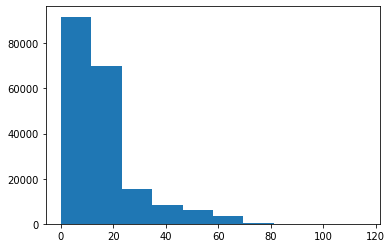

In [ ]:
# 문장길이의 분포를 시각화해본다.
plt.hist(num_tokens)
plt.show()

In [ ]:
x_train = np.array(X_train)
x_test = np.array(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


## 3. Model Training & Evaluation
- 3가지 모델로 영화리뷰 데이터를 훈련 및 평가해봅니다.    
(LSTM: RNN 계열로 nlp에 유용, CNN: 이미지 분석에 주로 사용되는 convolution layer이지만 텍스트 분류 모델에 사용 가능, GlobalMaxPooling: pooling layer로 임베딩벡터 분류)
- gensim 으로 embedding layer의 weight가 벡터공간에 잘 구성되어있는지 평가해봅니다.
- pretrained korean word2vec를 가져와서 모델의 embedding layer에 활용합니다.

In [ ]:
vocab_size = len(word_to_index)  # 10000개 단어사전
word_vector_dim = 100    # 100차원 단어 벡터

# 검증 데이터셋을 분리해줍니다.
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
# 모델의 history를 시각화하는 함수를 정의합니다.
def visualize(history_dict):
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  
  fig = plt.figure(figsize=(8, 6))
  ax1 = fig.add_subplot(211)
  ax2 = fig.add_subplot(212)

# "bo"는 "파란색 점"입니다
  ax1.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
  ax1.plot(epochs, val_loss, 'b', label='Validation loss')
  ax1.set_title('Training and validation loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()

  ax2.plot(epochs, acc, 'bo', label='Training acc')
  ax2.plot(epochs, val_acc, 'b', label='Validation acc')
  ax2.set_title('Training and validation accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  
  plt.tight_layout()
  plt.show()

**본격적인 모델 구성**
> 아래 3개의 모델 구조는 노드를 참고했으며, 노드의 모델을 그대로 사용하면 테스트 정확도가 85%에 미치지 못했습니다.      
이를 개선하고자, dense layer 전에 dropout layer(rate=0.3)를 추가해서 test accuracy를 올렸습니다.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dropout(0.3))   # dropout layer 추가
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 1,007,777
Trainable params: 1,007,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 # epoch가 5를 넘어서면 val_accuracy가 떨어지는 것을 확인해서 5로 설정.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
229/229 [==============================] - 6s 21ms/step - loss: 0.4416 - accuracy: 0.8026 - val_loss: 0.3569 - val_accuracy: 0.8454
Epoch 2/5
229/229 [==============================] - 5s 22ms/step - loss: 0.3278 - accuracy: 0.8629 - val_loss: 0.3430 - val_accuracy: 0.8498
Epoch 3/5
229/229 [==============================] - 5s 22ms/step - loss: 0.2992 - accuracy: 0.8759 - val_loss: 0.3412 - val_accuracy: 0.8530
Epoch 4/5
229/229 [==============================] - 5s 23ms/step - loss: 0.2754 - accuracy: 0.8876 - val_loss: 0.3409 - val_accuracy: 0.8546
Epoch 5/5
229/229 [==============================] - 5s 23ms/step - loss: 0.2539 - accuracy: 0.8970 - val_loss: 0.3475 - val_accuracy: 0.8530


1537/1537 - 4s - loss: 0.3540 - accuracy: 0.8499
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
---------------------------


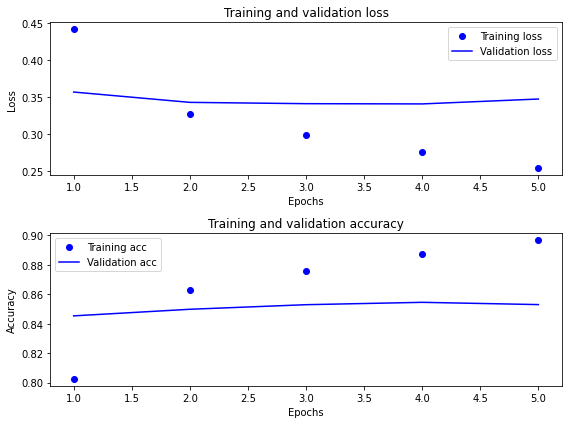

In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
print("---------------------------")
visualize(history_dict)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.3))   # dropout layer 추가
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          22432     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 32)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)              

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3     # val_accuracy가 떨어지지 않는 epoch 수를 설정해줍니다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
229/229 [==============================] - 5s 21ms/step - loss: 0.4633 - accuracy: 0.7690 - val_loss: 0.3440 - val_accuracy: 0.8500
Epoch 2/3
229/229 [==============================] - 5s 22ms/step - loss: 0.3105 - accuracy: 0.8723 - val_loss: 0.3286 - val_accuracy: 0.8569
Epoch 3/3
229/229 [==============================] - 5s 24ms/step - loss: 0.2477 - accuracy: 0.9033 - val_loss: 0.3441 - val_accuracy: 0.8574


1537/1537 - 3s - loss: 0.3534 - accuracy: 0.8542
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
---------------------------


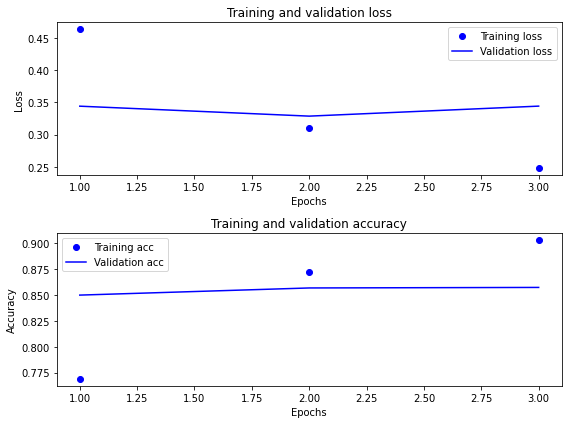

In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
print("---------------------------")
visualize(history_dict)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.3))   # dropout layer 추가
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 100)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
229/229 [==============================] - 4s 17ms/step - loss: 0.5050 - accuracy: 0.7598 - val_loss: 0.3628 - val_accuracy: 0.8402
Epoch 2/5
229/229 [==============================] - 4s 17ms/step - loss: 0.3450 - accuracy: 0.8514 - val_loss: 0.3416 - val_accuracy: 0.8507
Epoch 3/5
229/229 [==============================] - 4s 17ms/step - loss: 0.3107 - accuracy: 0.8689 - val_loss: 0.3391 - val_accuracy: 0.8533
Epoch 4/5
229/229 [==============================] - 4s 17ms/step - loss: 0.2870 - accuracy: 0.8804 - val_loss: 0.3421 - val_accuracy: 0.8521
Epoch 5/5
229/229 [==============================] - 4s 17ms/step - loss: 0.2699 - accuracy: 0.8885 - val_loss: 0.3446 - val_accuracy: 0.8517


1537/1537 - 2s - loss: 0.3528 - accuracy: 0.8487
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
---------------------------


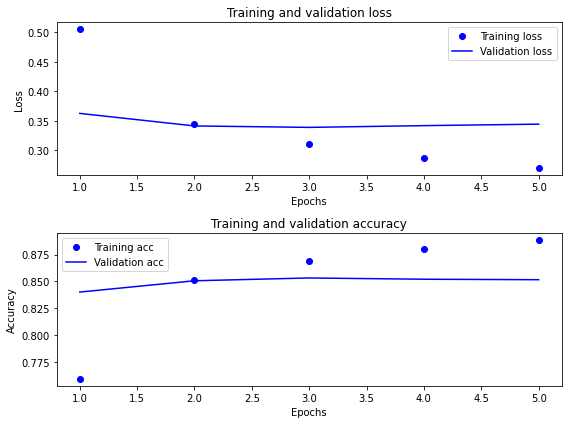

In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
print("---------------------------")
visualize(history_dict)

**모델 평가 정리** 
- 3개 모델 훈련 및 평가 결과, loss와 accuracy를 시각화한 그래프가 유사한 모습을 보입니다. training loss와 training accuracy는 각각 감소하고 증가하는데 validation loss와 validation accuracy는 개선되지 않고 변화가 없는 모양을 보입니다. 이는 3개 모델 모두 훈련 데이터셋에는 오버피팅되고 있으며, 테스트 데이터셋에 대한 정확도는 일정 수준을 벗어나지 못한다는 점을 보여줍니다.
- (아래 그림) epoch가 5를 넘어가면 오히려 validation accuracy가 떨어지고, validation loss는 증가하는 현상이 발생하면서 오버피팅이 심해진다는 것을 알 수 있었습니다. training loss는 감소하고, training accuracy도 90%를 넘어섰음에도 불구하고 테스트 데이터셋을 맞추는 정확도가 점점 낮아지는 것입니다. 따라서 epoch는 5로 설정해주었습니다.

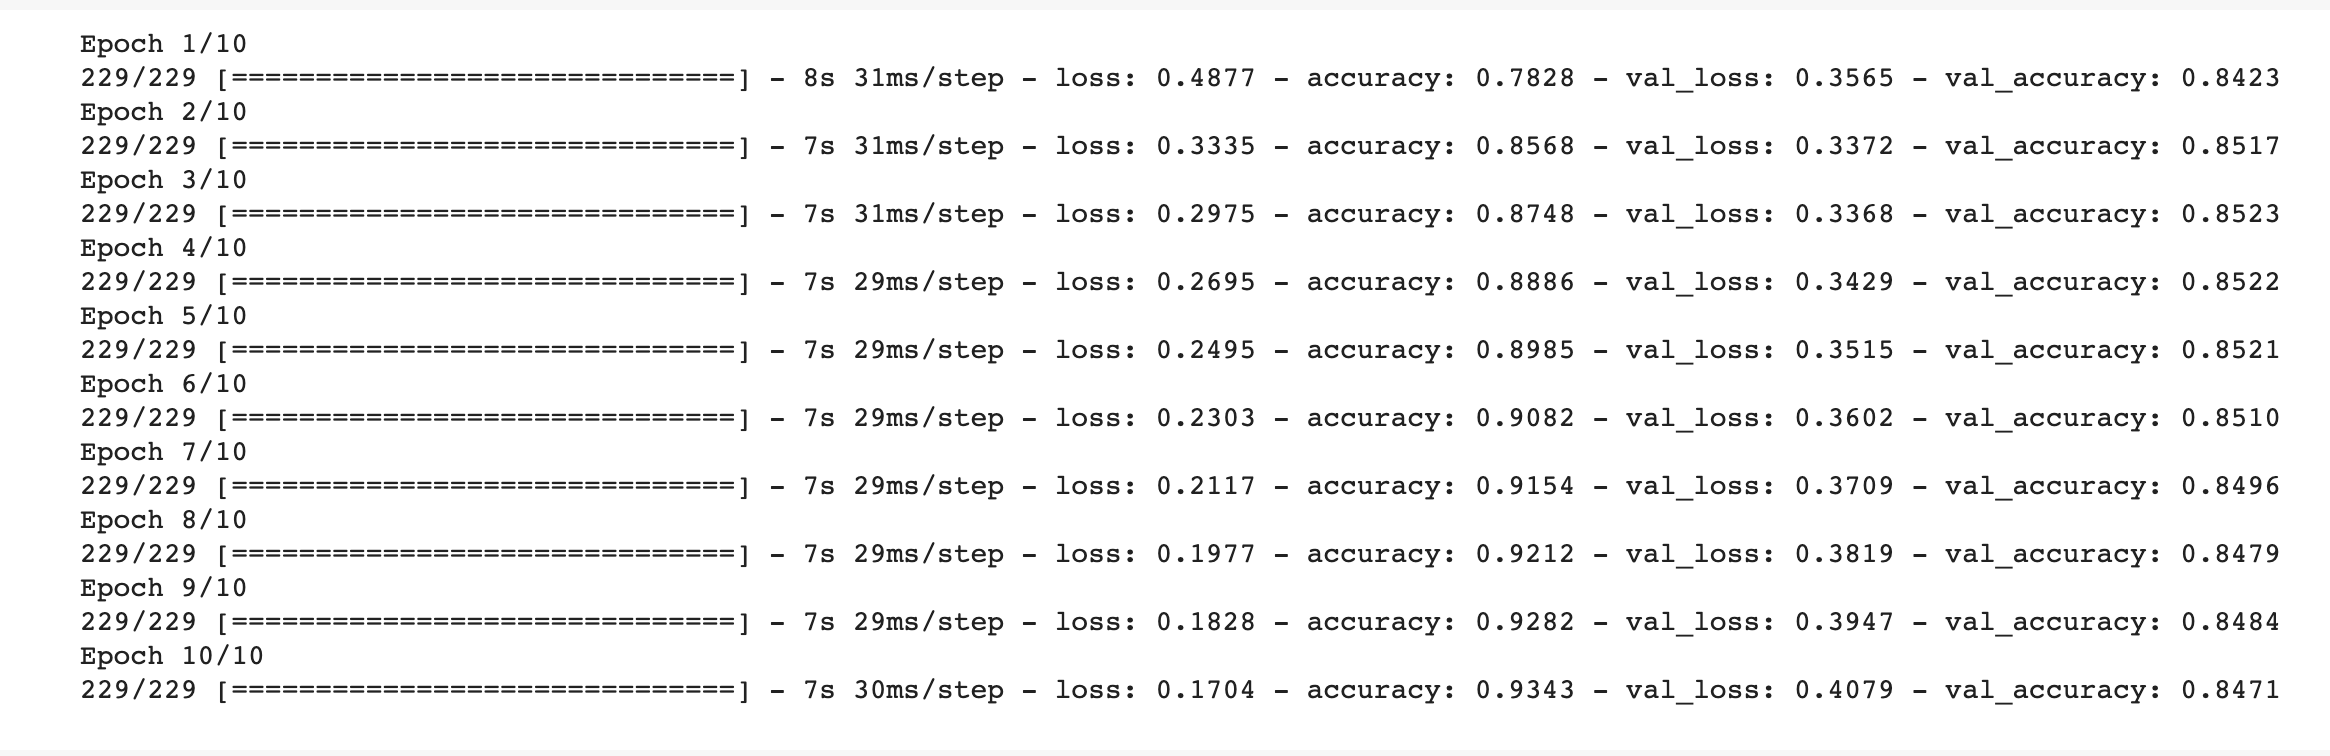

**임베딩 레이어를 gensim으로 분석**

In [ ]:
%cd '/content/drive/MyDrive/sentiment_classification'

/content/drive/MyDrive/sentiment_classification


In [ ]:
!pip install gensim

In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 100)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.00172239, -0.01084039,  0.00132807, -0.08903574,  0.04152831,
       -0.05667739, -0.00985014, -0.04297294, -0.01415298,  0.08794648,
       -0.06421419, -0.01959124, -0.06625115,  0.00510448, -0.03424963,
        0.05579205, -0.06685013, -0.00281378, -0.03225538,  0.09599168,
        0.0201087 , -0.06189896,  0.02729306, -0.01471377,  0.06445993,
        0.07424733, -0.04640458,  0.01865825,  0.05238771,  0.12805778,
       -0.06521933, -0.10606438,  0.01831707, -0.03755601,  0.09216556,
       -0.06085185, -0.06063149, -0.05415209, -0.01461059,  0.07124431,
       -0.0342978 , -0.05036067,  0.0201979 , -0.02210656, -0.02262294,
       -0.06431177, -0.10418733,  0.0129995 , -0.07979594, -0.10916485,
        0.09096116, -0.05734424,  0.1005078 , -0.04958043,  0.02330215,
       -0.02945049, -0.02139065, -0.01774319, -0.05153545,  0.00893199,
       -0.07501499, -0.05113217, -0.09002002, -0.03096576, -0.06086092,
       -0.02001741, -0.06084745, -0.05096696, -0.04302623, -0.00

In [ ]:
word_vectors.similar_by_word("사랑")

[('눈물', 0.5531785488128662),
 ('아요', 0.5431814193725586),
 ('진수', 0.5403304100036621),
 ('퍼지', 0.5401608347892761),
 ('소지섭', 0.5344120264053345),
 ('장면', 0.5169563293457031),
 ('존경', 0.5154414176940918),
 ('~~', 0.5153906345367432),
 ('핫', 0.5091923475265503),
 ('자유', 0.5004719495773315)]

- 위에서 훈련한 모델의 임베딩레이어를 벡터로 가져온 word2vec 에서 '사랑'이란 단어와 거리가 가까운 단어들이 딱히 관련이 없어보입니다.

**pretrained word2vec를 gensim으로 분석**

In [ ]:
# pretrained 한글 word2vec (https://github.com/Kyubyong/wordvectors)을 불러옵니다.
word2vec_path = '/content/drive/MyDrive/sentiment_classification/ko.bin'

from gensim.models import Word2Vec
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [ ]:
word2vec.similar_by_word("사랑")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

- pretrained 한글 word2vec을 가져왔더니, '사랑'과 거리가 가까운 유사한 단어들이 출력되었습니다.

**모델의 embedding layer에 pretrained word2vec 적용**

In [ ]:
# Embedding layer에 pretrained word2vec 을 활용해봅시다.
vocab_size = 10000   
word_vector_dim = 200  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 200  

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.3))   # dropout layer 추가
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 200)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 129       
Total params: 2,025,857
Trainable params: 2,025,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
229/229 [==============================] - 7s 29ms/step - loss: 0.6900 - accuracy: 0.5899 - val_loss: 0.6181 - val_accuracy: 0.6767
Epoch 2/30
229/229 [==============================] - 6s 28ms/step - loss: 0.6410 - accuracy: 0.6351 - val_loss: 0.5852 - val_accuracy: 0.7108
Epoch 3/30
229/229 [==============================] - 7s 28ms/step - loss: 0.6121 - accuracy: 0.6662 - val_loss: 0.5533 - val_accuracy: 0.7337
Epoch 4/30
229/229 [==============================] - 7s 29ms/step - loss: 0.5825 - accuracy: 0.6928 - val_loss: 0.5223 - val_accuracy: 0.7559
Epoch 5/30
229/229 [==============================] - 7s 29ms/step - loss: 0.5578 - accuracy: 0.7143 - val_loss: 0.5108 - val_accuracy: 0.7523
Epoch 6/30
229/229 [==============================] - 7s 29ms/step - loss: 0.5342 - accuracy: 0.7311 - val_loss: 0.4763 - val_accuracy: 0.7826
Epoch 7/30
229/229 [==============================] - 7s 29ms/step - loss: 0.5137 - accuracy: 0.7445 - val_loss: 0.4594 - val_accuracy: 0.7925

1537/1537 - 2s - loss: 0.3595 - accuracy: 0.8428
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
---------------------------


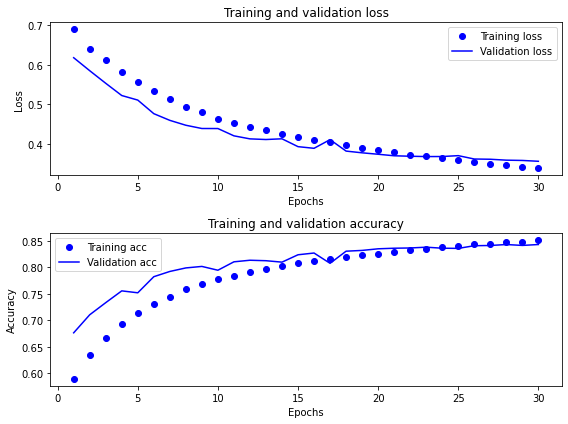

In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
print("---------------------------")
visualize(history_dict)

- word2vec으로 임베딩을 하니 오버피팅 문제는 줄어들었지만, 오히려 성능은 정확도 84% 수준으로 다른 모델들과 비교하면 살짝 떨어지네요. 사전 훈련된 임베딩 벡터가 성능이 그렇게 좋지 않다는 것을 확인할 수 있었습니다.
- 다음으로 성능을 올리고자 SKTBrain이 개발한 KoBert(사전 훈련된 언어모델)를 사용해서 훈련을 시켜보겠습니다.

## 4. KoBERT Sentiment Classification
https://github.com/SKTBrain/KoBERT 위 링크에서 pytorch를 활용한 KoBert 모델의 코랩노트북을 가져왔습니다. 가져온 코드를 활용해 제 구글 드라이브의 nsmc tsv파일 데이터를 학습하고 테스트했습니다.

> **BERT(Bidirectional Encoder Representations from Transformers)**
* 간단한 자연어처리의 역사: 사전 훈련된 워드임베딩(word2vec, FastText, GloVe)는 동음이의어, 다의어 경우에도 하나의 벡터에 매핑되는 문제가 있었다. 이를 개선하고자, 사전훈련된 언어모델이 등장해 Contextual Embedding이 가능해졌습니다. 2015년 구글에서 발표한 논문('Semi-supervised Sequence Learning')은 LSTM 사전훈련 모델을 제안했으며, 이후에는 ELMo(순방향 언어 모델과 역방향 언어 모델을 각각 따로 학습시킨 후에, 이렇게 사전 학습된 언어 모델로부터 임베딩 값을 얻는다)가 등장했습니다. 그리고 2018년에는 트랜스포머 모델이 등장하여 언어모델을 학습할 때 LSTM 대신 Transformer(RNN을 사용하지 않고, Attention만 사용해서 모델을 구성) 를 사용하는 사례가 증가했습니다.
* "BERT(Bidirectional Encoder Representations from Transformers)는 2018년에 구글이 공개한 사전 훈련된 모델입니다." 트랜스포머를 이용하여 구현되었으며, 레이블이 없는 방대한 텍스트 데이터(33억개 단어)를 학습한 사전 훈련 모델입니다. BERT를 파인튜닝해서 nlp 태스크에 맞게 사용한다면 성능이 향상되는 성과가 있다고 합니다. "BERT의 기본 구조는 트랜스포머의 인코더를 쌓아올린 구조입니다."     
출처: https://wikidocs.net/108730 , https://wikidocs.net/115055

> **KoBERT**
* "KoBERT는 기존 BERT의 한국어 성능 한계를 극복하기 위해 개발되었다. 위키피디아나 뉴스 등에서 수집한 수백만 개의 한국어 문장으로 이루어진 대규모말뭉치(corpus)를 학습하였으며, 한국어의 불규칙한 언어 변화의 특성을 반영하기 위해 데이터 기반 토큰화(Tokenization) 기법을 적용하여 기존 대비 27%의 토큰만으로 2.6% 이상의 성능 향상을 이끌어 냈다. 대량의 데이터를 빠른시간에 학습하기 위해 링 리듀스(ring-reduce) 기반 분산 학습 기술을 사용하여, 십억 개 이상의 문장을 다수의 머신에서 빠르게 학습한다. 더불어, 파이토치(PyTorch), 텐서플루(TensorFlow), ONNX, MXNet을 포함한 다양한 딥러닝 API를 지원함으로써, 많은 분야에서 언어 이해 서비스 확산에 기여하고 있다."    
출처: https://sktelecom.github.io/project/kobert/

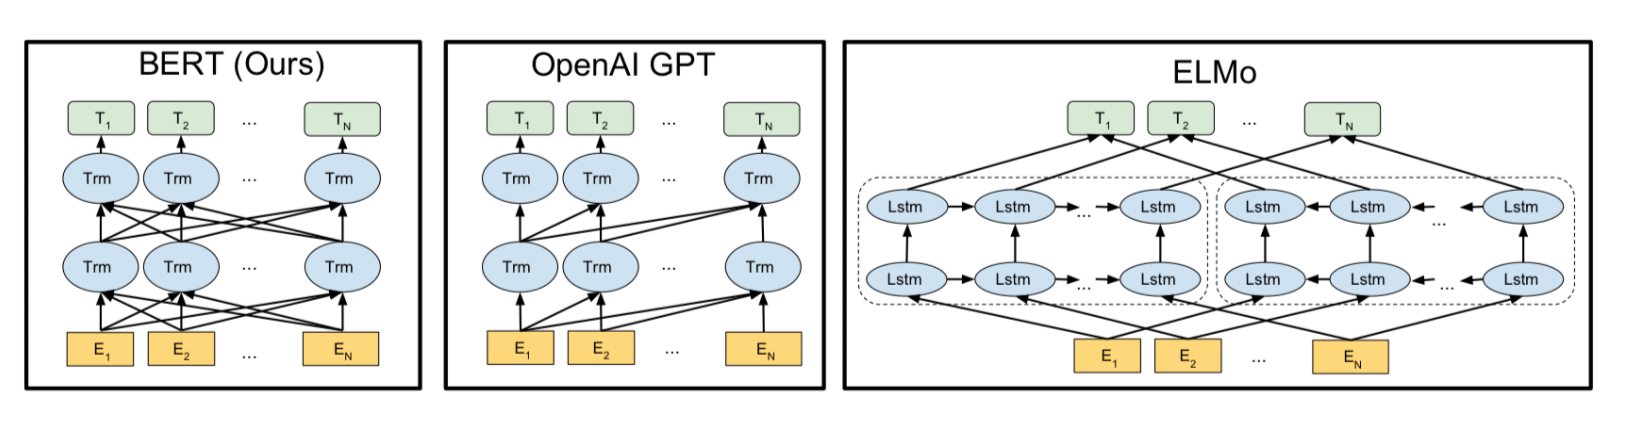

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-blwlp_kp
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-blwlp_kp


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [ ]:
# tsv 파일을 읽어옵니다.
dataset_train = nlp.data.TSVDataset("/content/drive/MyDrive/sentiment_classification/ratings_train.tsv", field_indices=[1,2], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset("/content/drive/MyDrive/sentiment_classification/ratings_test.tsv", field_indices=[1,2], num_discard_samples=1)

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
## Setting parameters
max_len = 41
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
# 메모리 용량이 부족하지 않도록
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    
    # KoBert모델로 nsmc 데이터셋을 훈련합니다.
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}\n".format(e+1, train_acc / (batch_id+1)))
    
    # KoBert로 학습한 모델을 평가해봅니다.
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}\n".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 0.7315358519554138 train acc 0.5
epoch 1 batch id 201 loss 0.5255932807922363 train acc 0.5729166666666666
epoch 1 batch id 401 loss 0.4665767550468445 train acc 0.6819279925187033
epoch 1 batch id 601 loss 0.4113122820854187 train acc 0.7305272462562395
epoch 1 batch id 801 loss 0.38248029351234436 train acc 0.7587975967540574
epoch 1 batch id 1001 loss 0.31812894344329834 train acc 0.7757867132867133
epoch 1 batch id 1201 loss 0.37508535385131836 train acc 0.7882623855120733
epoch 1 batch id 1401 loss 0.3805949091911316 train acc 0.7973099571734475
epoch 1 batch id 1601 loss 0.33365583419799805 train acc 0.8055414584634604
epoch 1 batch id 1801 loss 0.27474451065063477 train acc 0.811962104386452
epoch 1 batch id 2001 loss 0.34668394923210144 train acc 0.8178879310344828
epoch 1 batch id 2201 loss 0.28414827585220337 train acc 0.8227936165379373

epoch 1 train acc 0.8263651877133106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.8787963554987213


epoch 2 batch id 1 loss 0.5113121867179871 train acc 0.796875
epoch 2 batch id 201 loss 0.26986435055732727 train acc 0.8709577114427861
epoch 2 batch id 401 loss 0.28801819682121277 train acc 0.8746493142144638
epoch 2 batch id 601 loss 0.3416409492492676 train acc 0.878457778702163
epoch 2 batch id 801 loss 0.34399139881134033 train acc 0.8815738139825219
epoch 2 batch id 1001 loss 0.3076629936695099 train acc 0.8842095404595405
epoch 2 batch id 1201 loss 0.2450060397386551 train acc 0.8865008326394671
epoch 2 batch id 1401 loss 0.2043527513742447 train acc 0.8889520877944326
epoch 2 batch id 1601 loss 0.24303071200847626 train acc 0.8911617738913179
epoch 2 batch id 1801 loss 0.18156291544437408 train acc 0.8932537479178234
epoch 2 batch id 2001 loss 0.1940009593963623 train acc 0.8952789230384808
epoch 2 batch id 2201 loss 0.26341482996940613 train acc 0.8971206269877329

epoch 2 train acc 0.898495271615472



epoch 2 test acc 0.8881473785166241


epoch 3 batch id 1 loss 0.3067297637462616 train acc 0.890625
epoch 3 batch id 201 loss 0.17101456224918365 train acc 0.9188432835820896
epoch 3 batch id 401 loss 0.15155529975891113 train acc 0.9215632793017456
epoch 3 batch id 601 loss 0.20704147219657898 train acc 0.924110856905158
epoch 3 batch id 801 loss 0.20859618484973907 train acc 0.9259324282147315
epoch 3 batch id 1001 loss 0.23298631608486176 train acc 0.9275880369630369
epoch 3 batch id 1201 loss 0.16633109748363495 train acc 0.9298501248959201
epoch 3 batch id 1401 loss 0.09919023513793945 train acc 0.931845556745182
epoch 3 batch id 1601 loss 0.22390523552894592 train acc 0.933381480324797
epoch 3 batch id 1801 loss 0.13157182931900024 train acc 0.9349666851749028
epoch 3 batch id 2001 loss 0.137247234582901 train acc 0.9360632183908046
epoch 3 batch id 2201 loss 0.18700982630252838 train acc 0.9372160381644707

epoch 3 train acc 0.9382976926905574



epoch 3 test acc 0.8918238491048593


epoch 4 batch id 1 loss 0.44631102681159973 train acc 0.859375
epoch 4 batch id 201 loss 0.08748529851436615 train acc 0.9520366915422885
epoch 4 batch id 401 loss 0.07323399186134338 train acc 0.9531639650872819
epoch 4 batch id 601 loss 0.21331362426280975 train acc 0.9540609400998337
epoch 4 batch id 801 loss 0.19086621701717377 train acc 0.9557389200998752
epoch 4 batch id 1001 loss 0.15513309836387634 train acc 0.9571522227772228
epoch 4 batch id 1201 loss 0.04071347042918205 train acc 0.9581598667776853
epoch 4 batch id 1401 loss 0.031622644513845444 train acc 0.9596716630977873
epoch 4 batch id 1601 loss 0.02521204762160778 train acc 0.9604836820737039
epoch 4 batch id 1801 loss 0.07081553339958191 train acc 0.9614710577456969
epoch 4 batch id 2001 loss 0.07078717648983002 train acc 0.9621283108445777
epoch 4 batch id 2201 loss 0.08904679119586945 train acc 0.9628577919127669

epoch 4 train acc 0.9635238907849829



epoch 4 test acc 0.8933423913043478


epoch 5 batch id 1 loss 0.3439762592315674 train acc 0.890625
epoch 5 batch id 201 loss 0.048349346965551376 train acc 0.9705379353233831
epoch 5 batch id 401 loss 0.08267150074243546 train acc 0.9731920199501247
epoch 5 batch id 601 loss 0.11665395647287369 train acc 0.9730917221297837
epoch 5 batch id 801 loss 0.09708271920681 train acc 0.9741924157303371
epoch 5 batch id 1001 loss 0.1635201871395111 train acc 0.9747127872127872
epoch 5 batch id 1201 loss 0.06189863011240959 train acc 0.9753200457951707
epoch 5 batch id 1401 loss 0.019361574202775955 train acc 0.9756312455389008
epoch 5 batch id 1601 loss 0.014685545116662979 train acc 0.9759915677701436
epoch 5 batch id 1801 loss 0.010109348222613335 train acc 0.9763933231538034
epoch 5 batch id 2001 loss 0.06996173411607742 train acc 0.9764180409795102
epoch 5 batch id 2201 loss 0.09637868404388428 train acc 0.9765447523852794

epoch 5 train acc 0.9768158063139932



epoch 5 test acc 0.8938019501278772


## 5. Retrospective
- 역시나 텍스트 데이터를 다룰 때는 전처리 과정이 필수이며, 중요합니다. 먼저 토큰화와 임베딩으로 텍스트를 벡터 공간에 표현한 후 임베딩된 텍스트 데이터의 분류를 학습하고 테스트 데이터를 분류할 수 있습니다.
- 노드에서 배운 3가지 모델(LSTM, CNN, GlobalMaxPooling)로 감성분류를 했을 때는 오버피팅의 문제가 있었습니다. 훈련 데이터셋에만 정확도가 높아지고, 검증 데이터셋에서는 정확도가 개선되지 않았습니다. 감성분석 정확도를 85% 위로 올리기가 쉽지 않았습니다.
- 그래서 SKTBrain이 개발한 KoBert 를 가져와서 nsmc 감성분석을 실험해보았습니다. 아쉬웠던 점은 제가 모델 구조를 온전히 파악하지 못했고, 훈련시간이 지나치게 많이 걸렸습니다.(총 약 150분 가량 걸림. 1 에포크 당 훈련에는 20분 내외, 테스트에는 3분 내외) 그리고 이해하기 어려웠던 부분은, 1번째 에포크에서 훈련 정확도보다 테스트 정확도가 높다는 것입니다. 제 추측은 사전훈련된 언어모델을 가져왔기 때문에 애초에 koBERT의 성능이 감성분석을 꽤 잘 수행하고 있는 것 같습니다. 5번 epoch 훈련의 결과는 테스트 정확도가 89% 가량으로 올라가며 성능이 좋아진 것 같습니다. 다만, 코드를 거의 그대로 가져왔기 때문에 내부적으로 문제가 있을 수 있습니다.
- 아직은 다른 모델이나 코드를 그대로 배껴와 내 데이터셋에 적용하는 수준이지만, 여러가지 실험을 해보면서 nlp에 대한 이해도를 기를 수 있었고, 더 다양한 모델들에 대한 이해도를 올리고 싶다는 생각이 들었습니다.